**This project aims to train an accurate classifier for 250 species of birds, based on the image dataset found here: https://www.kaggle.com/gpiosenka/100-bird-species. Transfer Learning was implemented using EfficientNetB7, and Keras tuner was utilised for hyperparameter selection**

**A classification accuracy of 96.16% was achieved.**

# Prerequisites

In [ ]:
#keras tuner installed for use later
!pip install keras-tuner

     |████████████████████████████████| 71kB 8.2MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=04861aa7fe7edf904280e5b276d5120a46a493ab6b6d5c05b55ec7c0b52760e3
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=943704676cc8e1ea47b9f3bcfc5a997a93fc934940ff342aa1585140de7b6ee1
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
#importing neccessary libraries

#general
import zipfile
import sys
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

#keras tuner
from kerastuner.tuners import RandomSearch
from kerastuner.tuners import Hyperband
from kerastuner.engine.hyperparameters import HyperParameters

#sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, accuracy_score, recall_score
import seaborn as sns

#Setting random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)

**The bird dataset can be downloaded quickly from my google drive if using google colab (transfer is between within google so very fast)**

In [ ]:
# bird dataset can be downloaded from here
#!pip install gdown # Execute this if you don't have gdown
!gdown --id 10IsZlWZIaUehKOIr0g_RVg7S8cEsxmqR

Downloading...
From: https://drive.google.com/uc?id=10IsZlWZIaUehKOIr0g_RVg7S8cEsxmqR
To: /content/birds.zip
1.66GB [00:10, 156MB/s]


**Alternatively use this link if not using google colab, but be warned it may be much slower**

In [ ]:
# alternative if not using google colab (uncomment below as needed)
# !curl -O http://homepages.cs.ncl.ac.uk/stephen.mcgough/Teaching/birds.zip

# Image Processing

**bird images extracted from zipped folder into working directory**

In [ ]:
#extracting zipped image files into directory
## Unzipping birds.zip
with zipfile.ZipFile('birds.zip', 'r') as zip_ref:
    zip_ref.extractall()
print('birds dataset extracted to working directory as "test, train and valid"\n')

birds dataset extracted to working directory as "test, train and valid"



**Using Keras' ImageDataGenerator to load images from directory in batches without overloading RAM.**

In [ ]:
# create a data generator
datagen = ImageDataGenerator(rescale=1/255)

In [ ]:
# training dataset
train_it = datagen.flow_from_directory('./train/', target_size=(224,224), color_mode='rgb', class_mode='sparse',batch_size=128)
# validation dataset
val_it = datagen.flow_from_directory('./valid/', target_size=(224,224), color_mode='rgb', class_mode='sparse',batch_size=128)
# test dataset
test_it = datagen.flow_from_directory('./test/', target_size=(224,224), color_mode='rgb', class_mode='sparse',batch_size=128, shuffle=False)

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


# Transfer Learning

**Importing EfficientNet and freezing the layers**

In [ ]:
!pip install -U efficientnet

     |████████████████████████████████| 51kB 8.7MB/s 


**Using EfficientNetB7**

In [ ]:
# Model Initialization

import efficientnet.keras as efn
efnb7_imagenet = efn.EfficientNetB7(input_shape=(224,224,3),weights='imagenet',include_top=False)
#freezing layers
for layer in efnb7_imagenet.layers:
    layer.trainable=False

258441216/258434480 [==============================] - 3s 0us/step


# Tuning

**Keras tuner was used to tune the final layers after the EfficientNetB7. The number of layers, number of units and learning rate were tuned.**

In [ ]:
# defining function for building model with using ResNet101V2 for transfer learning
# and setting up for keras tuner to find the best number of layers, units per
# layer and learning rate.

def build_model(hp):

  model=Sequential()

  model.add(efnb7_imagenet) #transfer learning (frozen)
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(BatchNormalization())

  for i in range(hp.Int('n_layers', 1, 3)):
    model.add(Dense(hp.Int(f'{i}_units', 512, 2048, 512),kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

  model.add(Dense(250,activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],
                optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate',
                min_value=1e-4,max_value=1e-2,sampling='LOG',default=1e-3)))
  
  print(model.summary())
  return model

**A random search was carried out accross the specified grid of posibilities to find the best set of hyperparameters**

In [ ]:
# setting up tuner object and how long to tune for
seed = 1 # seed to improve reproducability
executions_per_trial = 1
max_trials = 7
tuner = RandomSearch(build_model, max_trials = max_trials , objective = 'val_accuracy', seed=seed, executions_per_trial = executions_per_trial, directory = '/content/drive/MyDrive/LOG_DIR_efn')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 7, 7, 2560)        64097680  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2560)        0         
_________________________________________________________________
flatten (Flatten)            (None, 125440)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 125440)            501760    
_________________________________________________________________
dense (Dense)                (None, 512)               64225792  
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)               0

**Checking out the search space to make sure the search is feasible**

In [ ]:
# viewing the scope of the search, gives an indication of if it's going to take too long
tuner.search_space_summary()

Search space summary
Default search space size: 3
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
0_units (Int)
{'default': None, 'conditions': [], 'min_value': 512, 'max_value': 2048, 'step': 512, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


**Conducting the search using 3 epochs and a batch size of 256 to speed it up.**

In [ ]:
# executing search using validation data to evaluate
tuner.search(train_it, epochs=3, batch_size=256, validation_data=val_it)

Trial 7 Complete [00h 24m 07s]
val_accuracy: 0.7943999767303467

Best val_accuracy So Far: 0.9232000112533569
Total elapsed time: 02h 40m 57s
INFO:tensorflow:Oracle triggered exit


**Evaluating the results. Chose to go with the second best model in this list. This model was within 0.0015 of the top model; given that it has extra depth and during tuning looked like it would have continued improving more than the top model, I took a punt on the fact that over a longer training it would reach higher accuracy.**

In [ ]:
# viewing the results
print(tuner.results_summary())

Results summary
Results in /content/drive/MyDrive/LOG_DIR_efn/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
n_layers: 1
0_units: 2048
learning_rate: 0.0002991777241598977
Score: 0.9232000112533569
Trial summary
Hyperparameters:
n_layers: 1
0_units: 2048
learning_rate: 0.0005285006792644589
1_units: 1536
Score: 0.9215999841690063
Trial summary
Hyperparameters:
n_layers: 1
0_units: 1536
learning_rate: 0.006475590128522282
1_units: 512
Score: 0.9031999707221985
Trial summary
Hyperparameters:
n_layers: 1
0_units: 1536
learning_rate: 0.003860825451272157
Score: 0.8984000086784363
Trial summary
Hyperparameters:
n_layers: 2
0_units: 1024
learning_rate: 0.0008894905887153519
1_units: 1024
Score: 0.8944000005722046
Trial summary
Hyperparameters:
n_layers: 2
0_units: 1024
learning_rate: 0.0008433633337952192
1_units: 512
Score: 0.8863999843597412
Trial summary
Hyperparameters:
n_layers: 3
0_units: 2048
learning_rate: 0.0026

**Below blocks used to reload the tuner if needed**

In [ ]:
# #reloading the tuner from file
# tuner = RandomSearch(build_model, max_trials = max_trials , objective = 'val_accuracy', seed=seed, executions_per_trial = executions_per_trial, directory = './LOG_DIR_efn')
# tuner.reload()

In [ ]:
# previously run tuner ('LOG_DIR) can be dowloaded from here
#!pip install gdown # Execute this if you don't have gdown
# !gdown --id 1Jr-wBG9Av9eDaiVZ-jlJkanTXVPTJKlW
# print('tuner downloaded to environment, run cell beow like usual and it itll show the best parameters')

Permission denied: https://drive.google.com/uc?id=1Jr-wBG9Av9eDaiVZ-jlJkanTXVPTJKlW
Maybe you need to change permission over 'Anyone with the link'?
tuner downloaded to environment, run cell beow like usual and it itll show the best parameters


# Defining final model

**The model chosen above using keras tuner is defined as `model_tuned` ready for full training**

In [ ]:
#defining the hyperparameters chosen from tuning
tuned_lr = 0.0005285006792644589
tuned_layer_1 = 2048
tuned_layer_2 = 1536

model_tuned=Sequential()
model_tuned.add(efnb7_imagenet)
model_tuned.add(Dropout(0.5))
model_tuned.add(Flatten())
model_tuned.add(BatchNormalization())

model_tuned.add(Dense(tuned_layer_1,kernel_initializer='he_uniform'))
model_tuned.add(BatchNormalization())
model_tuned.add(Activation('relu'))
model_tuned.add(Dropout(0.5))

model_tuned.add(Dense(tuned_layer_2,kernel_initializer='he_uniform'))
model_tuned.add(BatchNormalization())
model_tuned.add(Activation('relu'))
model_tuned.add(Dropout(0.5))

model_tuned.add(Dense(250,activation='softmax'))
model_tuned.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(tuned_lr))

print(model_tuned.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 7, 7, 2560)        64097680  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2560)        0         
_________________________________________________________________
flatten (Flatten)            (None, 125440)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 125440)            501760    
_________________________________________________________________
dense (Dense)                (None, 2048)              256903168 
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0

# Training

**The tuned model is trained with early stopping, allowing the best model to be saved automatically. Early stopping is quite useful for this model as from previous experiments it was clear the accuracy oscillates about the optimal value after a certain number of epochs.**

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mc = ModelCheckpoint('/content/drive/MyDrive/best_model_2.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model_tuned.fit(train_it,epochs=10 , validation_data=val_it, callbacks=[es, mc])

Epoch 1/10
276/276 [==============================] - 439s 2s/step - loss: 4.9194 - accuracy: 0.1056 - val_loss: 1.0463 - val_accuracy: 0.7360

Epoch 00001: val_accuracy improved from -inf to 0.73600, saving model to /content/drive/MyDrive/best_model_2.h5
Epoch 2/10
276/276 [==============================] - 473s 2s/step - loss: 1.8301 - accuracy: 0.5384 - val_loss: 0.4768 - val_accuracy: 0.8632

Epoch 00002: val_accuracy improved from 0.73600 to 0.86320, saving model to /content/drive/MyDrive/best_model_2.h5
Epoch 3/10
276/276 [==============================] - 472s 2s/step - loss: 1.2326 - accuracy: 0.6702 - val_loss: 0.3618 - val_accuracy: 0.8928

Epoch 00003: val_accuracy improved from 0.86320 to 0.89280, saving model to /content/drive/MyDrive/best_model_2.h5
Epoch 4/10
276/276 [==============================] - 478s 2s/step - loss: 1.0010 - accuracy: 0.7327 - val_loss: 0.2911 - val_accuracy: 0.9168

Epoch 00004: val_accuracy improved from 0.89280 to 0.91680, saving model to /conte

**It's clear from the plot below that the validation accuracy is not improving with more epochs after a certain point. Early stopping was triggered after 10 epochs due to no increase in validation accuracy between 9 and 10 epochs. Interestingly, the validation accuracy is consistently higher than the training accuracy, perhaps the validation data contains less outlying examples than the training data.**

Done!


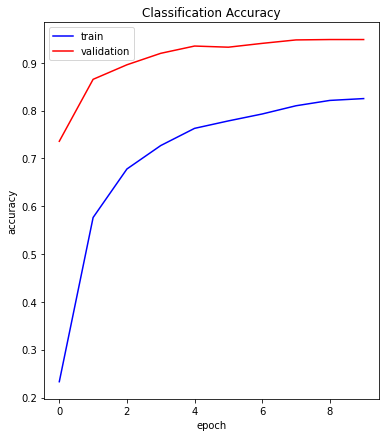

In [ ]:
# Function used to plot the curves for loss and accuracy:
def plot_curves(history):

  # Plotting the accuracy curve:
  plt.subplot(212)
  plt.title('Classification Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  # Plotting the training accuracy (blue):
  plt.plot(history.history['accuracy'], color='blue', label='train')
  # Plotting the test accuracy (red):
  plt.plot(history.history['val_accuracy'], color='red', label='test')
  # Legend for the plot:
  plt.legend(['train', 'validation'], loc='upper left')

  plt.subplots_adjust(top=3)
  plt.show()

print('Done!')
plot_curves(model_tuned.history)

# Loading Model

**The trained model was uploaded to google drive, and is publicly available for download in the code block below if you just want to use the model for inference:**

In [ ]:
# #Trained model can be downloaded from here (ignore this if you already have the .h5 file)
# !gdown --id 1-9rvlgWSmFIHexWVCturjafgP1IdDpeH

Downloading...
From: https://drive.google.com/uc?id=1-9rvlgWSmFIHexWVCturjafgP1IdDpeH
To: /content/best_model_3.h5
3.39GB [00:54, 62.3MB/s]


**Use below to load the model (make sure the model is in working directory or change the filepath below):**

In [ ]:
model_tuned = load_model('./best_model_3.h5')
print('--------------------')
print('Trained model loaded')
print('--------------------')

--------------------
Trained model loaded
--------------------


# Results

**The model accuracy is evaluated:**

In [ ]:
# evaluate model
test_acc = model_tuned.evaluate(test_it)
print('-----------------------------------------------------------------------------------')
print(f'The model classified the species of birds with {round(test_acc[1]*100,2)}% accuracy')
print('-----------------------------------------------------------------------------------')

10/10 [==============================] - 17s 1s/step - loss: 0.1373 - accuracy: 0.9616
-----------------------------------------------------------------------------------
The model classified the species of birds with 96.16% accuracy
-----------------------------------------------------------------------------------


**Ground truth and predicted classes are saved for use in the confusion matrix**

In [ ]:
# using model to predict species of bird
predicted_classes = np.argmax(model_tuned.predict(test_it), axis=-1)
# defining ground truth classes
gt_classes = test_it.classes

print(gt_classes.tolist())
print(predicted_classes.tolist())

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 52, 52, 5

**Accuracy, precision and recall reported. Precision and recall were calculated using macro averaging.**

In [ ]:
#calculating accuracy, precision and recall
print('====================')
print(f'accuracy: {accuracy_score(gt_classes, predicted_classes)}')
print('====================')
print(f'precision: {round(precision_score(gt_classes, predicted_classes, average="macro"),4)}')
print('====================')
print(f'recall: {recall_score(gt_classes, predicted_classes, average="macro")}')
print('====================')

accuracy: 0.9616
precision: 0.9676
recall: 0.9616


**A confusion matrix/heatmap was created using seaborn and pyplot, based on the prediction of species in the test set (1250 images). The colour scale on the side shows the coresponding colours to how many classes were predicted for each truth/prediction pair. Ideally everywhere would be completely black except for the diagonal (represents ground truth and prediction matching). The reality is not far of this, with only a few classification mistakes dotted arround. Two species were misclassified as the same species twice (two maroon dots), likely meaning that the model is getting confused between the two birds due to similarities.**

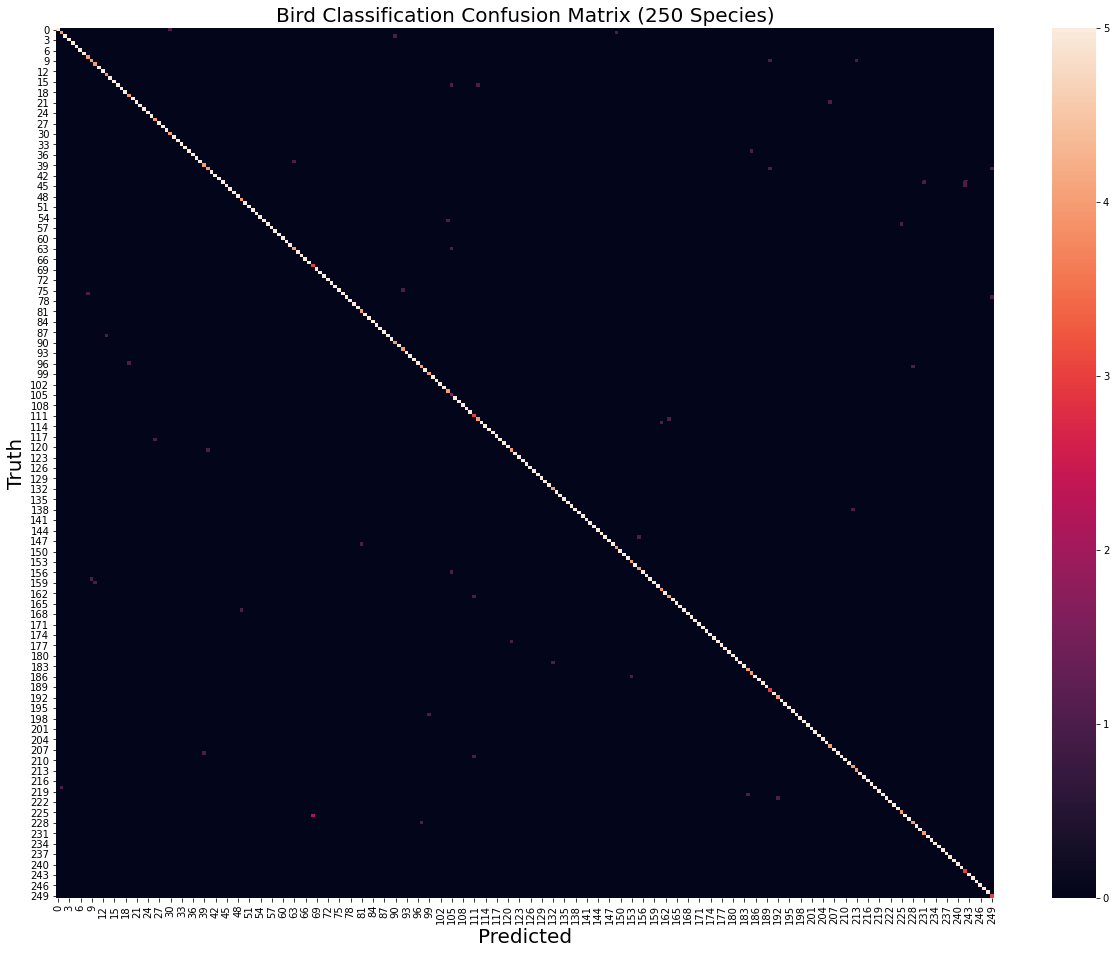

In [ ]:
#creating confusion matrix from ground truth and predicted values for 'Survived'
cmbird = confusion_matrix(predicted_classes, gt_classes)

#Formatting confusion matrix into heatmap.
plt.figure(figsize = (21,16))
sns.heatmap(cmbird, fmt='')
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Truth', fontsize=20)
plt.title('Bird Classification Confusion Matrix (250 Species)', fontsize=20);

#saving for use in report
plt.savefig('cmbird.png')

# Inference

**The species dictionary is printed to examine it's structure**

In [ ]:
train_it.class_indices

{'AFRICAN CROWNED CRANE': 0,
 'AFRICAN FIREFINCH': 1,
 'ALBATROSS': 2,
 'ALEXANDRINE PARAKEET': 3,
 'AMERICAN AVOCET': 4,
 'AMERICAN BITTERN': 5,
 'AMERICAN COOT': 6,
 'AMERICAN GOLDFINCH': 7,
 'AMERICAN KESTREL': 8,
 'AMERICAN PIPIT': 9,
 'AMERICAN REDSTART': 10,
 'ANHINGA': 11,
 'ANNAS HUMMINGBIRD': 12,
 'ANTBIRD': 13,
 'ARARIPE MANAKIN': 14,
 'ASIAN CRESTED IBIS': 15,
 'BALD EAGLE': 16,
 'BALI STARLING': 17,
 'BALTIMORE ORIOLE': 18,
 'BANANAQUIT': 19,
 'BANDED BROADBILL': 20,
 'BAR-TAILED GODWIT': 21,
 'BARN OWL': 22,
 'BARN SWALLOW': 23,
 'BARRED PUFFBIRD': 24,
 'BAY-BREASTED WARBLER': 25,
 'BEARDED BARBET': 26,
 'BELTED KINGFISHER': 27,
 'BIRD OF PARADISE': 28,
 'BLACK FRANCOLIN': 29,
 'BLACK SKIMMER': 30,
 'BLACK SWAN': 31,
 'BLACK THROATED WARBLER': 32,
 'BLACK VULTURE': 33,
 'BLACK-CAPPED CHICKADEE': 34,
 'BLACK-NECKED GREBE': 35,
 'BLACK-THROATED SPARROW': 36,
 'BLACKBURNIAM WARBLER': 37,
 'BLUE GROUSE': 38,
 'BLUE HERON': 39,
 'BOBOLINK': 40,
 'BROWN NOODY': 41,
 'BROWN THRAS

**The trained model is writetn into a function `classify_bird()`, which takes a filepath as input, and outputs the image with a species label. A percentage certainty value is also attached which represents the maximum probability value output by the softmax function of the model *100.**

In [ ]:
# Using the pre-trained model to make a classifier function

# saving dictionary of species
dic=train_it.class_indices
# switching keys and values around for indexing
spec_label={k:v for v,k in dic.items()}

def classify_bird(filepath):
  # loading image
  image=load_img(filepath,target_size=(224,224,3))
  # converting image to array
  image=img_to_array(image)
  # converting from 0-155 to 0-1
  image=image/255
  image=np.expand_dims(image,[0])
  # predict the probability across all output classes
  yhat = np.argmax(model_tuned.predict(image), axis=-1)
  # convert the probabilities to class labels
  label = spec_label[yhat[0]]
  # calculating the percentage certainty
  perc = np.max(model_tuned.predict(image)*100)
  #loading image
  img = load_img(filepath, target_size=(224,224,3))
  #displaying image
  plt.imshow(img)
  #setting title to classification
  plt.title("I'm {:0.2f}% sure this is a {}".format(perc, label))

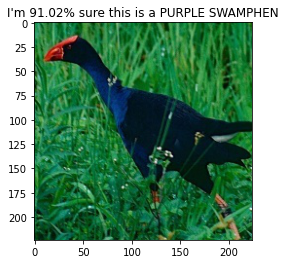

In [ ]:
classify_bird('/content/consolidated/consolidated/PURPLE SWAMPHEN/001.jpg')

# References

Brownlee, J., 2021. Transfer Learning in Keras with Computer Vision Models. [online] Machine Learning Mastery. Available at: <https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/> [Accessed 18 February 2021].

Brownlee, J., 2021. How to Configure Image Data Augmentation in Keras. [online] Machine Learning Mastery. Available at: <https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/> [Accessed 25 February 2021].

Huilgol, P., 2020. Top 4 Pre-Trained Models for Image Classification | With Python Code. [online] Analytics Vidhya. Available at: <https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/> [Accessed 24 February 2021].

Medium. 2021. A guide to transfer learning with Keras using ResNet50. [online] Available at: <https://medium.com/@kenneth.ca95/a-guide-to-transfer-learning-with-keras-using-resnet50-a81a4a28084b> [Accessed 17 February 2021].

Mohajon, J., 2021. Confusion Matrix for Your Multi-Class Machine Learning Model. [online] Medium. Available at: <https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826> [Accessed 19 February 2021].

Pythonprogramming.net. 2021. Python Programming Tutorials. [online] Available at: <https://pythonprogramming.net/keras-tuner-optimizing-neural-network-tutorial/> [Accessed 17 February 2021].

Sicara.ai. 2021. [online] Available at: <https://www.sicara.ai/blog/hyperparameter-tuning-keras-tuner> [Accessed 18 February 2021].

Srivastava, Nitish & Hinton, Geoffrey & Krizhevsky, Alex & Sutskever, Ilya & Salakhutdinov, Ruslan. (2014). Dropout: A Simple Way to Prevent Neural Networks from Overfitting. Journal of Machine Learning Research. 15. 1929-1958.